In [1]:
import random
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from sklearn import preprocessing, cluster, model_selection, metrics

In [2]:
synInputData = pd.read_csv('input.csv',header=None).values
synOutputData = pd.read_csv('output.csv',header=None).values
letorInputData = pd.read_csv('Querylevelnorm_X.csv',header=None).values
letorOutputData = pd.read_csv('Querylevelnorm_t.csv',header=None).values


# print(synInputData.shape)
# print(synOutputData.shape)
# print(letorInputData.shape)
# print(letorOutputData.shape)

In [69]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(synInputData, synOutputData, test_size=0.20, shuffle=False)
X_validate, X_test, y_validate, y_test = model_selection.train_test_split(X_test, y_test, test_size=0.50, shuffle=False)

In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(letorInputData, letorOutputData, test_size=0.20, shuffle=False)
X_validate, X_test, y_validate, y_test = model_selection.train_test_split(X_test, y_test, test_size=0.50, shuffle=False)

In [42]:
def compute_design_matrix(X_train, k_clusters):
    
    N,D = X_train.shape
    kmeans = cluster.KMeans(k_clusters).fit(X_train)
    centers = kmeans.cluster_centers_
    centers = centers[:,np.newaxis,:]
    spreads = []
#     covM = np.cov(X_train.T)
    covM = np.identity(D)
    for _ in range(0,k_clusters): spreads.append(covM)
    spreads = np.array(spreads)
    X = X_train[np.newaxis,:,:]
    
    basis_func_outputs = np.exp(np. sum(np.matmul(X - centers, spreads) * (X - centers), axis=2) / (-2) ).T
    return np.insert(basis_func_outputs, 0, 1, axis=1)

In [43]:
def closed_form_solution(l2_lamda, designMatrix, outValues):
    weights = np.dot(np.dot(np.linalg.inv(np.dot(designMatrix.T,designMatrix)),designMatrix.T),outValues)
    return weights

In [44]:
def SGD(learningRate, l2_lamda, designMatrix, outValues, miniBatchSize, numEpochs,k_clusters):
    N=designMatrix.shape[0]
    weights = np.zeros([1, k_clusters+1])
    for epoch in range(numEpochs):
        for i in range(int(N / miniBatchSize)):
            lower_bound = i * miniBatchSize
            upper_bound = min((i+1)*miniBatchSize, N)
            Phi = designMatrix[lower_bound : upper_bound, :]
            t = outValues[lower_bound : upper_bound, :]
            E_D = np.matmul((np.matmul(Phi, weights.T)-t).T,Phi )
            E = (E_D + l2_lamda * weights) / miniBatchSize
            weights = weights - learningRate * E
    return weights.flatten()
    

In [45]:
def rms_error(weights, designMatrix, Y, l2_lamda):
    y_calc = np.dot(designMatrix,weights)
#     print(y_calc.shape)
    E_D_W = 0.5*metrics.mean_squared_error(Y,y_calc)*designMatrix.shape[0]
    E_W_W = 0.5*np.dot(weights.T,weights)
    E_W = E_D_W + l2_lamda*E_W_W
    train_error = np.sqrt(2*E_W/designMatrix.shape[0])
#     print(train_error.shape)
    return train_error

In [20]:
k_cluster = 16

In [18]:
#Hyper-parameter tuning
l2_lamda = 0.9


designMatrix = compute_design_matrix(X_train,k_cluster)
weights_train0 = closed_form_solution(l2_lamda, designMatrix, y_train)
train_error0 = rms_error(weights_train0,designMatrix,y_train,l2_lamda)
print("Training error:",train_error0)

designMatrix2 = compute_design_matrix(X_validate,k_cluster)
train_error2 = rms_error(weights_train0,designMatrix2,y_validate,l2_lamda)
print("Test error (Validation set):",train_error2)


#Test error
designMatrix3 = compute_design_matrix(X_test,k_cluster)
train_error3 = rms_error(weights_train0,designMatrix3,y_test,l2_lamda)
print("Test error (test set):",train_error3)

Training error: [[ 0.54869675]]
Test error (Validation set): [[ 1.71304706]]
Test error (test set): [[ 5.62787587]]


In [19]:
#Hyper-parameter tuning
l2_lamda = 0.9
learning_rate = 0.001

designMatrix = compute_design_matrix(X_train,k_cluster)
weights_train0 = SGD(learning_rate, l2_lamda, designMatrix,y_train, designMatrix.shape[0],5000,k_cluster)
train_error0 = rms_error(weights_train0,designMatrix,y_train,l2_lamda)
print("Training error:",train_error0)

designMatrix2 = compute_design_matrix(X_validate,k_cluster)
train_error2 = rms_error(weights_train0,designMatrix2,y_validate, l2_lamda)
print("Test error (Validation set):",train_error2)

#Test error
designMatrix3 = compute_design_matrix(X_test,k_cluster)
train_error3 = rms_error(weights_train0,designMatrix3,y_test, l2_lamda)
print("Test error (test set):",train_error3)

Training error: 0.557899017515
Test error (Validation set): 0.556575941747
Test error (test set): 0.641825907726


In [ ]:
#Test error
designMatrix = compute_design_matrix(X_validate,16)
# weights_train2 = closed_form_solution(0.1, designMatrix, y_test)
# weights_train3 = SGD(0.01, 0.1, designMatrix,y_test, designMatrix.shape[0],100,16)
train_error2 = rms_error(weights_train0,designMatrix,y_validate)
print(train_error2)
# train_error3 = rms_error(weights_train3,designMatrix,y_test)
# print(train_error3)

In [ ]:
train_error0 = rms_error(weights_train0,designMatrix,y_train)
print(train_error0)
# train_error1 = rms_error(weights_train1,designMatrix,y_train)
# print(train_error1)

In [ ]:
designMatrix = compute_design_matrix(X_train,16)

weights_train0 = closed_form_solution(0.5, designMatrix, y_train)

# weights_train1 = SGD(0.01, 0.1, designMatrix,y_train, designMatrix.shape[0],100000,16)
# weights_train1 = SGD(0.01, 0.1, designMatrix,y_train, 1,100000,16)

In [6]:
covM = np.cov(X_train.T)
covM.shape

(46, 46)

In [1]:
# A = np.identity(2)
# A = np.dstack((A,np.identity(2)))
# A = np.stack((A,np.identity(2)))
# # for _ in range(0,2):
# #     A = np.dstack((A,np.identity(2)))

In [7]:
x = np.array([[0, 2], [1, 1], [2, 0]]).T
x

array([[0, 1, 2],
       [2, 1, 0]])

In [6]:
np.cov(x)

array([[ 2.,  0., -2.],
       [ 0.,  0.,  0.],
       [-2.,  0.,  2.]])

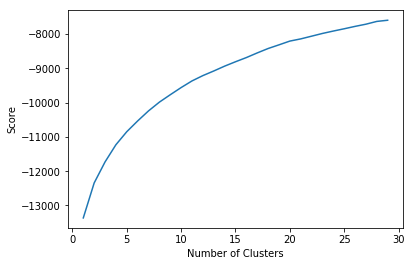

In [70]:
# A=[]
# I1 = np.eye(2)
# for i in range(0,5):
#     A.append(I1)
# A = np.array(A)
# A.shape

import pylab as pl
Nc = range(1, 30)
kmeans = [cluster.KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(X_train).score(X_train) for i in range(len(kmeans))]
score
pl.plot(Nc,score)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
# pl.title('Elbow Curve')
pl.show()

In [67]:
import pylab as pl
i=0
lambdass= [0.001, 0.002,0.004, 0.006, 0.01, 0.05, 0.08, 0.1, 0.2]
# lambdass = [0.05, 0.1,0.2,0.4,0.8,1,1.2,1.5,2]
LAQ = np.zeros((3,np.array(lambdass).shape[0]))
for la in lambdass:
    A = test2(la)
    LAQ[0][i] = A[0]
    LAQ[1][i] = A[1]
    LAQ[2][i] = A[2]
    i=i+1

Training error: 0.742650560757
Test error (Validation set): 0.76896027352
Test error (test set): 0.75803945296
Training error: 0.725610911046
Test error (Validation set): 0.761893247341
Test error (test set): 0.760380511445
Training error: 0.700851220738
Test error (Validation set): 0.768131250285
Test error (test set): 0.725368662974
Training error: 0.682019261328
Test error (Validation set): 0.752972425512
Test error (test set): 0.75445929514
Training error: 0.64581388877
Test error (Validation set): 0.757162770872
Test error (test set): 0.810659566868
Training error: 0.596265839625
Test error (Validation set): 0.818478359581
Test error (test set): 0.900340306961
Training error: 0.5917591893
Test error (Validation set): 0.87690828221
Test error (test set): 0.804340037375
Training error: 0.595443920283
Test error (Validation set): 0.780046032752
Test error (test set): 0.856542848435
Training error: 0.594875471127
Test error (Validation set): 0.857362466491
Test error (test set): 0.792

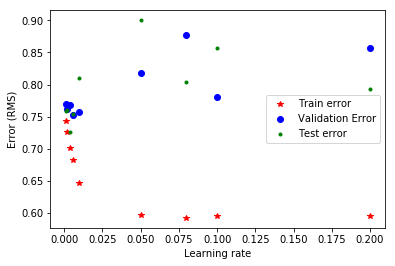

In [68]:
pl.plot(lambdass,LAQ[0,:],'r*')
pl.plot(lambdass,LAQ[1,:],'bo')
pl.plot(lambdass,LAQ[2,:],'g.')
pl.xlabel('Learning rate')
pl.ylabel('Error (RMS)')
plt.legend(('Train error', 'Validation Error','Test error'))
pl.show()

In [24]:
lambdass= [0.05, 0.1, 0.2, 0.4, 0.8, 1, 1.2, 1.5, 2]
LAQ = np.zeros((3,np.array(lambdass).shape[0]))
LAQ.shape

(3, 9)

In [26]:
A = test1(1)
A[0]

Training error: [[ 0.54861499]]
Test error (Validation set): [[ 1.56211109]]
Test error (test set): [[ 1.27836241]]


array([[ 0.54861499]])

In [51]:
def test1(la):
#Hyper-parameter tuning
    l2_lamda = la
    designMatrix = compute_design_matrix(X_train,k_cluster)
    weights_train0 = closed_form_solution(l2_lamda, designMatrix, y_train)
    train_error0 = rms_error(weights_train0,designMatrix,y_train,l2_lamda)
    print("Training error:",train_error0)
    designMatrix2 = compute_design_matrix(X_validate,k_cluster)
    train_error2 = rms_error(weights_train0,designMatrix2,y_validate,l2_lamda)
    print("Test error (Validation set):",train_error2)
    #Test error
    designMatrix3 = compute_design_matrix(X_test,k_cluster)
    train_error3 = rms_error(weights_train0,designMatrix3,y_test,l2_lamda)
    print("Test error (test set):",train_error3)
    return train_error0,train_error2,train_error3

In [65]:
def test2(la):
#Hyper-parameter tuning
    l2_lamda = 0.9
    learning_rate = la

    designMatrix = compute_design_matrix(X_train,k_cluster)
    weights_train0 = SGD(learning_rate, l2_lamda, designMatrix,y_train, designMatrix.shape[0],5000,k_cluster)
    train_error0 = rms_error(weights_train0,designMatrix,y_train,l2_lamda)
    print("Training error:",train_error0)

    designMatrix2 = compute_design_matrix(X_validate,k_cluster)
    train_error2 = rms_error(weights_train0,designMatrix2,y_validate, l2_lamda)
    print("Test error (Validation set):",train_error2)

    #Test error
    designMatrix3 = compute_design_matrix(X_test,k_cluster)
    train_error3 = rms_error(weights_train0,designMatrix3,y_test, l2_lamda)
    print("Test error (test set):",train_error3)
    return train_error0,train_error2,train_error3